In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import h5py
import hdf5plugin
import os

from settings import base_fold_raw_data, base_fold_input_data

In [3]:
EVENTS_DTYPE = [("t", "<u4"), ("x", "<u2"), ("y", "<u2"), ("p", "<u2")]

In [4]:
SEQUENCE_LENGTH = 3.0  # in seconds
SEQUENCE_LENGTH_MS = SEQUENCE_LENGTH * 1000.0  # in milliseconds
DT_MS = 10.0  # 100 fps

COLL_TYPE = "none_with_traffic"
DIAMETER_OBJECT = np.nan
VELOCITY = np.nan
T_END = SEQUENCE_LENGTH

METADATA = {
    "coll_type": COLL_TYPE,
    "t_end": T_END,
    "dt": DT_MS,
    "vel": VELOCITY,
    "diameter_object": DIAMETER_OBJECT,
}

"""
"coll_type": self.coll_type,
"t_end": self.t * 1000,
"dt": self.dt * 1000,
"vel": avg_vel,
"diameter_object": avg_dim,
"""

'\n"coll_type": self.coll_type,\n"t_end": self.t * 1000,\n"dt": self.dt * 1000,\n"vel": avg_vel,\n"diameter_object": avg_dim,\n'

In [5]:
scenes = os.listdir(base_fold_raw_data)

metadata = {}

file_path_sq_id = []

scene_sq_id = []

for scene in scenes:
    file_path = os.path.join(base_fold_raw_data, scene, "events/left/events.h5")
    with h5py.File(file_path, "r") as f:
        metadata[scene] = {}
        ms_t = f["ms_to_idx"]
        metadata[scene]["sequence_length"] = len(ms_t) / 1000.0
        metadata[scene]["num_sequences"] = int(len(ms_t) / SEQUENCE_LENGTH_MS)

        file_path_sq_id.extend([file_path] * metadata[scene]["num_sequences"])
        scene_sq_id.extend(range(metadata[scene]["num_sequences"]))

N_SQ = len(file_path_sq_id)

sq_by_id = dict(zip(range(N_SQ), [{"scene_sq_id": id, "file_path": file_path} for id, file_path in zip(scene_sq_id, file_path_sq_id)]))

In [ ]:
prev_path = None

for i, sq in sq_by_id.items():
    print(f"Processing sequence {i + 1}/{N_SQ}", end="\r")
    scene_sq_id = sq["scene_sq_id"]
    file_path = sq["file_path"]
    if file_path != prev_path:
        file = h5py.File(file_path, "r")
        prev_path = file_path
    
        ms_to_idx = file["ms_to_idx"]
        x = file["events/x"]
        y = file["events/y"]
        t = file["events/t"]
        p = file["events/p"]
    
    start_idx = ms_to_idx[int(scene_sq_id * SEQUENCE_LENGTH_MS)]
    end_idx = ms_to_idx[int((scene_sq_id + 1) * SEQUENCE_LENGTH_MS)]

    _x = x[start_idx:end_idx]
    _y = y[start_idx:end_idx]
    _t = t[start_idx:end_idx]
    _t = ((_t - _t[0]) / 1000.0).astype(np.uint32) # microseconds to milliseconds and shift to start at 0
    _p = p[start_idx:end_idx]

    # optional: remove "duplicate" events in a millisecond bin (by downsampling to 1ms)
    '''
    _t = _t.astype(np.int32)
    _unique_id = _t * 640 * 480 + _y * 640 + _x
    # find unique events. This returns the index of the *first* appearance of each unique event,
    # which, in this case, would be the first event in a given millisecond at a given location (ignoring polarity).
    _, idx = np.unique(_unique_id, return_index=True)
    _x = _x[idx]
    _y = _y[idx]
    _t = _t[idx]
    _p = _p[idx]
    '''

    # construct a structurred array events
    # can we avoid zip?
    events = np.empty(len(_t), dtype=EVENTS_DTYPE)
    events["t"] = _t
    events["x"] = _x
    events["y"] = _y
    events["p"] = _p

    # save the data

    output_fold = os.path.join(base_fold_input_data, f"example_{i}/")

    if not os.path.exists(output_fold):
        os.makedirs(output_fold)
    
    print(f"Saving sequence {i + 1}/{N_SQ} to {output_fold}", end="\r")
    np.save(os.path.join(output_fold, "events.npy"), events)
    np.savez(os.path.join(output_fold, "sim_data.npz"), **METADATA)

KeyboardInterrupt: 

In [8]:
print(file.keys())

<KeysViewHDF5 ['events', 'ms_to_idx', 't_offset']>


In [38]:
ms_to_idx = file["ms_to_idx"]
x = file["events/x"]
y = file["events/y"]
t = file["events/t"]
p = file["events/p"]

T_MAX_MS = ms_to_idx.shape[0]
N_SEQUENCES = int(T_MAX_MS / SEQUENCE_LENGT_MS)
print(N_SEQUENCES)

19


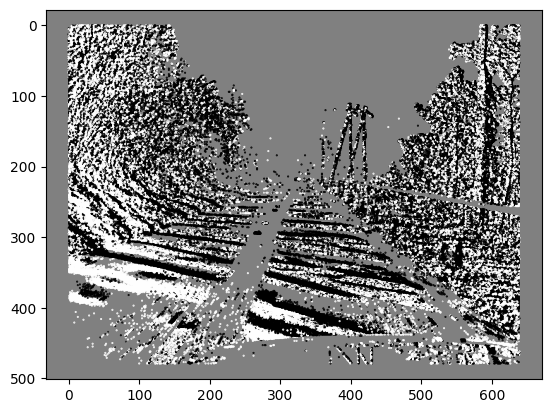

In [44]:
SEQU_IND = np.random.randint(0, N_SEQUENCES)
T_MS = int(SEQU_IND * SEQUENCE_LENGT_MS)
t0 = ms_to_idx[T_MS]
t1 = ms_to_idx[T_MS + int(DT_MS)]

_x = x[t0:t1]
_y = y[t0:t1]
_p = p[t0:t1]
_t = t[t0:t1]

events = np.array(list(zip(_t, _x, _y, _p)), dtype=EVENTS_DTYPE)

plt.scatter(_x, _y, c=_p, s=0.25, cmap="gray")
plt.axis('equal')
# flip y axis
plt.gca().invert_yaxis()
# make background gray
plt.gca().set_facecolor('0.5')

plt.show()

In [35]:
events

array([(20000000,  14, 326, 0), (20000000, 588, 326, 0),
       (20000000, 610, 326, 0), ..., (20000999,  49, 158, 1),
       (20000999,  56, 158, 0), (20000999,   6, 159, 1)],
      shape=(15373,), dtype=[('t', '<u4'), ('x', '<u2'), ('y', '<u2'), ('p', '<u2')])